In [1]:
from fair.forcing.ghg import meinshausen
from fair.defaults.thermal import q, d
from fair.defaults.carbon import a, tau as alpha_co2
#from tqdm.notebook import tqdm
%matplotlib inline
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.interpolate import interp1d
from scipy.signal import fftconvolve
from scipy.integrate import cumtrapz
from scipy.stats import multivariate_normal, norm
import random

In [2]:
#import sys
#sys.path.append('./ar6-main')

from Clone_chrisroadmap.ar6.metrics.halogen_generic import halogen_analytical
from Clone_chrisroadmap.ar6.metrics.co2 import co2_analytical
from Clone_chrisroadmap.ar6.metrics.ch4 import ch4_analytical
from Clone_chrisroadmap.ar6.metrics.n2o import n2o_analytical
from Clone_chrisroadmap.ar6.metrics.gasser import carbon_cycle_adjustment

In [3]:
halo = np.genfromtxt(
    'Data_input/hodnebrog20.csv',
    delimiter=',',
    comments='£', # seemed to work better than None
    names=True,
    dtype="U30, U20, U20, U30, f8, f8, f8",
    usecols = (0, 1, 2, 3, 4, 5, 6)
)
#halo

In [4]:
# read in as .CSV, to extract the row-index of any user-defined gas name 
halo_df = pd.read_csv('Data_input/hodnebrog20.csv') 
halo_df

,Name,CASRN,Acronym,Formula,Molar mass,Lifetime (yr),RE (W m-2 ppb-1),AGWP 20-yr,GWP 20-yr,AGWP 100-yr,GWP 100-yr,AGWP 500-yr,GWP 500-yr,AGTP 20-yr,GTP 20-yr,AGTP 50-yr,GTP 50-yr,AGTP 100-yr,GTP 100-yr,Column1
0,Chlorofluorocarbons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Trichlorofluoromethane,75-69-4,CFC-11,CCl3F,0.13736,52.0,0.25941,1.768880e-10,7724.0,4.730360e-10,5866.0,5.539710e-10,2056.0,4.293140e-12,7931.0,2.744940e-12,6021.0,1.415840e-12,3415.0,NaN
2,Dichlorodifluoromethane,75-71-8,CFC-12,CCl2F2,0.12091,102.0,0.31998,2.711400e-10,11840.0,9.515090e-10,11799.0,1.511500e-09,5611.0,6.962290e-12,12862.0,5.727750e-12,12564.0,4.145060e-12,9998.0,NaN
3,Chlorotrifluoromethane,75-72-9,CFC-13,CClF3,0.10446,640.0,0.27752,2.951220e-10,12887.0,1.387560e-09,17207.0,5.200580e-09,19304.0,7.951750e-12,14690.0,8.204800e-12,17997.0,8.371480e-12,20192.0,NaN
4,1:2-Difluoro-1:1:2:2-tetrachloroethane,76-12-0,CFC-112,CCl2FCCl2F,0.20382,63.6,0.28192,1.339070e-10,5847.0,3.932720e-10,4877.0,4.960890e-10,1841.0,3.319380e-12,6132.0,2.328710e-12,5108.0,1.351070e-12,3259.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,Phosphoric trichloride,10025-87-3,Phosphorous oxychloride,P(O)Cl3,NaN,NaN,0.10450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,Titanium tetrachloride,7550-45-0,NaN,TiCl4,NaN,NaN,0.01643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
639,Tungsten hexafluoride,7783-82-6,NaN,WF6,NaN,NaN,0.08562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
640,Carbonyl Fluoride,353-50-4,NaN,CF2O,NaN,NaN,0.12300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Select any halocarbon to calculate
<p>because too many halocarbons, user only choose the gas of interest for further calculation and enter their name below </p>
<b><font color='red'>suggesting not to select over 3 gases, running time will be long</font></b>

In [5]:
def user_inputhalo_andcheck(halo_df):
    while True:
        value = input("Enter selected halocarbons, seperate by semicolon ';'  ")
        user_input_halo = [x.strip() for x in value.split(';')]   #strip out all space

        if all(item in halo_df['Name'].to_list() for item in user_input_halo): 
            print("you entered:" + str(user_input_halo))
            break
        else:
            print("Wrong name input, re-enter, goto 'hodnebrog20.csv' for name check. Seperate gas by semicolon ';' (under Eng keyboard).")
            continue

    return user_input_halo

In [7]:
user_halo = user_inputhalo_andcheck(halo_df)

Enter selected halocarbons, seperate by semicolon ';'  Sulfur hexafluoride; (E)-1:2-Dichlorohexafluorocyclobutane
you entered:['Sulfur hexafluoride', '(E)-1:2-Dichlorohexafluorocyclobutane']


In [8]:
user_halo
#halo_df.loc[halo_df['Name'] == user_halo[0]]

['Sulfur hexafluoride', '(E)-1:2-Dichlorohexafluorocyclobutane']

In [9]:
ispec_list = []
for h in user_halo: 
    ispec_list.append(halo_df.index[halo_df['Name'] == h].tolist()[0])

In [10]:
ispec_list

[166, 11]

### Define initial parameters
<li>Define baseline GHG concentrations  ppm/ppb </li>
<li>Define timestep per year (use 10 to align with Table7.SM.7, or use 1 for faster calculation)</li>
<li>Define time horizon, default is 500 yrs, or use 20/100 for shorter period</li>

In [11]:
co2 = 409.9
ch4 = 1866.3
n2o = 332.1

In [12]:
ts_per_year = 10
H_max = 500  # years

### Begin calculation_CO2 (CO2 AGWP needed to calculate GWP for each gas)

In [13]:
rf_co2, agwp_co2, agtp_co2, iagtp_co2 = co2_analytical(
    np.linspace(0, H_max, H_max * ts_per_year + 1),
    #np.linspace(0, H_max, int(H_max * ts_per_year) + 1),   # in case tstep not interger
    d=np.array([3.424102092311, 285.003477841911]),        #parameters used to calculate AGTP
    q = np.array([0.443767728883447, 0.313998206372015]),  
    co2=co2, n2o=n2o,
    a=np.array([0.2173, 0.2240, 0.2824, 0.2763]),   #parameters for AGWP, same a0/a1/a2/a3 as in AR5  
    alpha_co2=np.array([0, 394.4, 36.54, 4.304]),   #parameters for AGWP, same tau0/tau1/tau2/tau3 as in AR5 
    co2_ra = 0.05
)

### Begin calculate selected Halo

In [14]:
for ispec in ispec_list:
    name = halo[ispec]['Name']
    chem_name = halo[ispec]['Formula']
    alpha = halo[ispec]['Lifetime_yr']
    re = halo[ispec]['RE_W_m2_ppb1']
    if (halo[ispec]['Acronym']=='CFC-11' or halo[ispec]['Acronym'] == 'CFC-12'):
        cfc_ra = 0.12
    else:
        cfc_ra = 0
    mass = halo[ispec]['Molar_mass']

    print(name, chem_name, alpha, re, cfc_ra, mass)

Sulfur hexafluoride SF6 3200.0 0.56657 0 0.14607
(E)-1:2-Dichlorohexafluorocycl trans cyc (-CClFCF2CF2CClF-) 75.0 0.26963 0 0.23294


In [15]:
# prepare excel (each gas will be saved to a seperate sheet)
writer = pd.ExcelWriter('Data_output/halo_RF_calc.xlsx', engine='xlsxwriter')

# will save all dict calculated (dynamic dict name-vars() ) to a list
all_halo_calc = []

# begin calculate the gas selected by users "user_halo"
for ispec in ispec_list:
    name = halo[ispec]['Name']
    chem_name = halo[ispec]['Formula']
    # delete all "_ : - ( )" characters in the formular (use Formular instead of full name as the latter too long for some), 
    # the new formular name will be used for naming the dynamic {dict} after calculation
    chem_name_new = ''.join(x for x in chem_name if x.isalpha() or x.isnumeric())
    alpha = halo[ispec]['Lifetime_yr']
    re = halo[ispec]['RE_W_m2_ppb1']
    if (halo[ispec]['Acronym']=='CFC-11' or halo[ispec]['Acronym'] == 'CFC-12'):
        cfc_ra = 0.12
    else:
        cfc_ra = 0
    mass = halo[ispec]['Molar_mass']


    if not np.isnan(alpha):
    #  Pulse each (rf...) are np.array
        rf, agwp, agtp, iagtp = halogen_analytical(
            np.linspace(0, H_max, H_max * ts_per_year + 1),
            alpha,
            re,
            mass,
            d=np.array([3.424102092311, 285.003477841911]),
            #q=np.array([0.443767728883447, 0.319591049742508]),    # this is what is in Zeb's file sent 25 Feb
            q = np.array([0.443767728883447, 0.313998206372015]),   # this is what Bill used
            halogen_ra = cfc_ra
        )
    
        rf_cc, agwp_cc, agtp_cc = carbon_cycle_adjustment(
            np.linspace(0, H_max, H_max * ts_per_year + 1),
            agtp,
            co2=co2,
            n2o=n2o,
            co2_ra = 0.05,
        d = np.array([3.424102092311, 285.003477841911]),
        #q=np.array([0.443767728883447, 0.319591049742508]),    # this is what is in Zeb's file sent 25 Feb
        q = np.array([0.443767728883447, 0.313998206372015]),   # this is what Bill used
        )


    # Step
        if alpha < 20.:
            rf_cc, agwp_cc, agtp_cc = carbon_cycle_adjustment(
                np.linspace(0, H_max, H_max * ts_per_year + 1),
                iagtp,
                co2=co2,
                n2o=n2o,
                co2_ra = 0.05,
                d = np.array([3.424102092311, 285.003477841911]),
                #q=np.array([0.443767728883447, 0.319591049742508]),    # this is what is in Zeb's file sent 25 Feb
                q = np.array([0.443767728883447, 0.313998206372015]),   # this is what Bill used
                )
        #else:  #will affect GTP calculation, won't impact on AGWP
    

    #store all values to a dict w/h dynamic names, within each dict, key_name start with the chemical formular 
    #(e.g.SF6, if formular contains non letter/number, then re-named to chem_name_new)
    vars()[chem_name_new+'_result'] = {chem_name_new+"_rf":rf, chem_name_new+"_agwp":agwp, chem_name_new+"_agtp":agtp, chem_name_new+"_iagtp":iagtp, 
                              chem_name_new+"_rf_cc":rf_cc, chem_name_new+"_agwp_cc":agwp_cc, chem_name_new+"_agtp_cc":agtp_cc}
    
    all_halo_calc.append(vars()[chem_name_new+'_result'])
    
    # save dict to excel, different sheet for each gas, sheetname is chemical formular
    df_calc = pd.DataFrame(vars()[chem_name_new+'_result'])
    df_calc.to_excel(writer, sheet_name=str(chem_name), index = False)

writer.save()

In [16]:
all_halo_calc

[{'SF6_rf': array([2.18818319e-11, 2.18811481e-11, 2.18804644e-11, ...,
         1.87176925e-11, 1.87171076e-11, 1.87165227e-11]),
  'SF6_agwp': array([0.00000000e+00, 2.18814900e-12, 4.37622963e-12, ...,
         1.01252461e-08, 1.01271179e-08, 1.01289896e-08]),
  'SF6_agtp': array([0.00000000e+00, 2.81896027e-13, 5.55738131e-13, ...,
         1.34612413e-11, 1.34612380e-11, 1.34612345e-11]),
  'SF6_iagtp': array([0.00000000e+00, 1.41629011e-14, 5.61107489e-14, ...,
         6.17745638e-09, 6.17880250e-09, 6.18014863e-09]),
  'SF6_rf_cc': array([0.00000000e+00, 5.17780044e-16, 1.52055644e-15, ...,
         1.07379004e-12, 1.07368935e-12, 1.07358864e-12]),
  'SF6_agwp_cc': array([0.00000000e+00, 0.00000000e+00, 5.15916264e-17, ...,
         5.75833073e-10, 5.75940448e-10, 5.76047814e-10]),
  'SF6_agtp_cc': array([0.00000000e+00, 0.00000000e+00, 6.64635859e-18, ...,
         7.79475531e-13, 7.79443722e-13, 7.79411887e-13])},
 {'transcycCClFCF2CF2CClF_rf': array([6.53003145e-12, 6.521330

In [17]:
plt.style.use('dark_background')

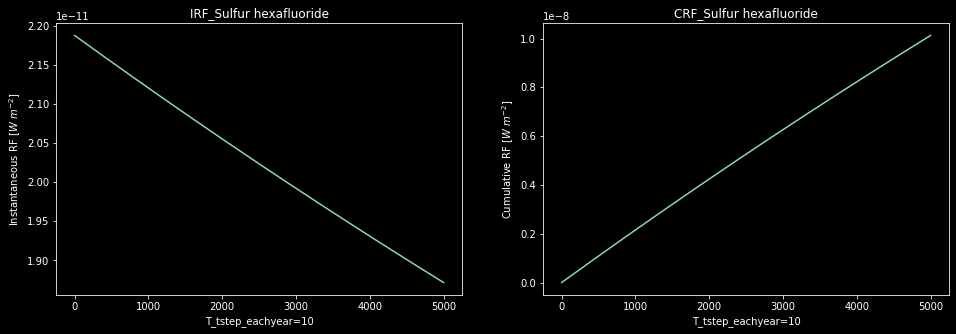

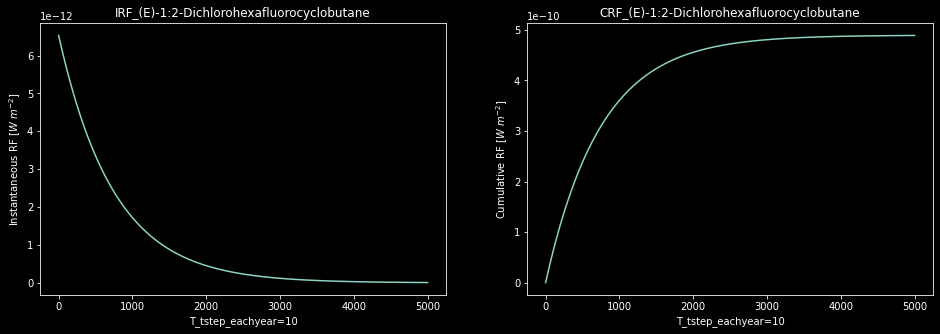

In [18]:
for i in range(len(all_halo_calc)):
        
    IRF_toplot = all_halo_calc[i].get([k for k in all_halo_calc[i].keys() if k.endswith('rf')][0]) 
    CRF_toplot = all_halo_calc[i].get([k for k in all_halo_calc[i].keys() if k.endswith('agwp')][0])

    #the one-line code equals to: 
    #for k in all_halo_calc[i].keys(): if k.endswith('rf'): IRF_toplot = all_halo_calc[i].get(k)

    # plot IRF CRF
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

    ax1.plot(IRF_toplot)
    ax1.set(xlabel='T_tstep_eachyear=' + str(ts_per_year), ylabel= "Instantaneous RF [" + '$W \ m^{-2}$' + ']')
    ax1.set_title('IRF_' + user_halo[i])

    ax2.plot(CRF_toplot)
    ax2.set(xlabel='T_tstep_eachyear=' + str(ts_per_year), ylabel= "Cumulative RF [" + '$W \ m^{-2}$' + ']')
    ax2.set_title('CRF_' + user_halo[i])

<h3>Calculate final AGWP, DCF</h3>
<h4>For CH4, N2O, and Halo, in AR6, using ERF (instead of RF in AR1-5),  final_agwp != agwp, as final_agwp = agwp + carbon cycle adjustment </h4>

In [19]:
def agwp_t_halo(agwp_self, agwp_cc, agwp_co2, tstep, HT):
    final_agwp = []
    final_gwp = []
    if len(agwp_self) == len(agwp_cc) == len(agwp_co2):
        for i in range(1,HT+1):
            final_agwp.append(agwp_self[i * tstep] + agwp_cc[i * tstep])   
            final_gwp.append( (agwp_self[i * tstep]+agwp_cc[i * tstep])/agwp_co2[i * tstep] )

    final_agwp.insert(0,0)  #insert 0 to the first element, so len is [501], same as H_max
    final_gwp.insert(0,0)

    return final_agwp, final_gwp

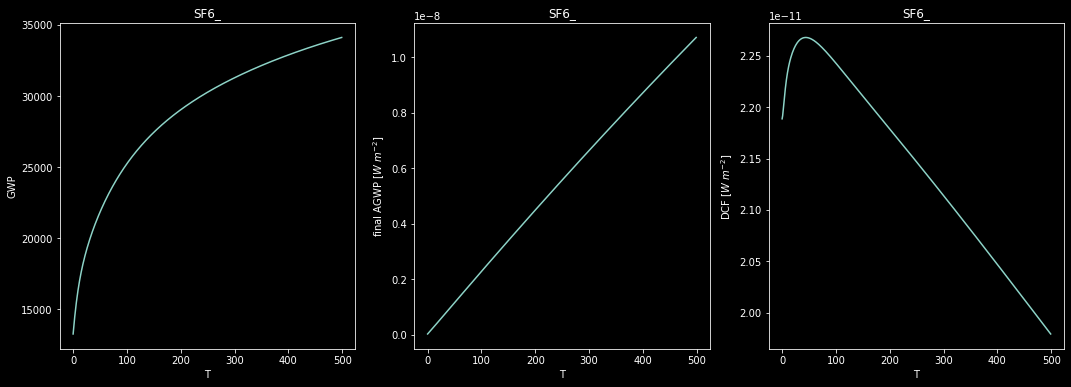

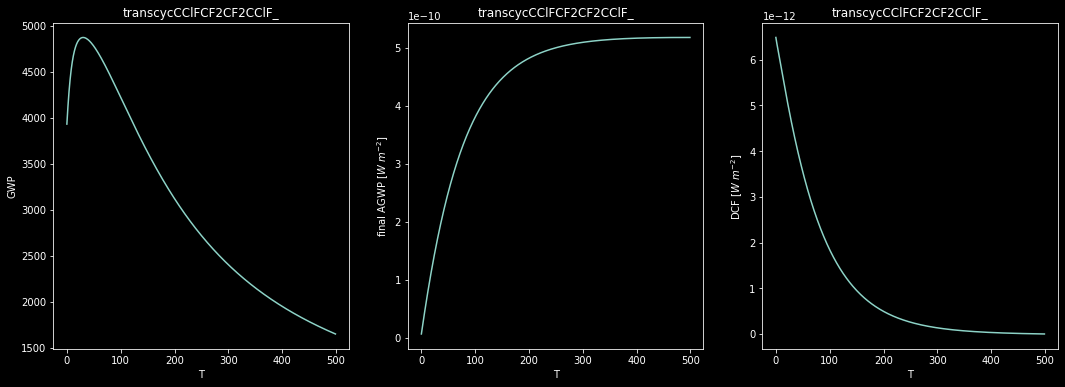

In [20]:
# prepare excel (store final calculated DCF of each halo)
writer = pd.ExcelWriter('Data_output/DCF_halo.xlsx', engine='xlsxwriter')

for halo_n in all_halo_calc:   # halo_n is the nth dict, with stored value rf, agwp... 
        
    for k in halo_n.keys():
        if k.endswith('agwp'):
            agwp = halo_n.get(k)   # halo_n.get([k for k in halo_n.keys() if k.endswith('agwp')][0]) 
            title = k.split('agwp')[0]    # title is the chem_name of gas, need for naming in saved excel
        elif k.endswith('agwp_cc'):
            agwp_cc = halo_n.get(k)
    
    final_agwp_halo, gwp_halo = agwp_t_halo(agwp, agwp_cc, agwp_co2, ts_per_year, H_max)
    
    DCF = np.diff(final_agwp_halo)
    DCF = np.insert(DCF, 0, final_agwp_halo[0])  #insert final_agwp_halo[0] to first value (DCF[0]) so they same len

    vars()[title+'_result'] = {title+"_AGWP[W/m2/kg]":final_agwp_halo, title+"_GWP":gwp_halo, title+"_DCF":DCF}

    # save dict to excel, different sheet for each halo, sheetname is chemical formular
    df_halo = pd.DataFrame(vars()[title+'_result'])
    df_halo.to_excel(writer, sheet_name=str(title))   #index = False, use default index to indicate year

    # plot GWP AGWP DCF (each year)
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    ax1.plot(np.delete(gwp_halo, 0))    #delete first 0 value for year[0] when ploting 
    ax1.set(xlabel='T', ylabel= "GWP")
    ax1.set_title(title)

    ax2.plot(np.delete(final_agwp_halo, 0))
    ax2.set(xlabel='T', ylabel= "final AGWP [" + '$W \ m^{-2}$' + ']')
    ax2.set_title(title)
    
    ax3.plot(np.delete(DCF, 0))
    ax3.set(xlabel='T', ylabel= "DCF [" + '$W \ m^{-2}$' + ']')
    ax3.set_title(title)

writer.save()